In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
%matplotlib inline
from nltk.corpus import stopwords
import nltk

In [11]:
df = pd.read_csv("data 1_train.csv")

In [12]:
a = [5,6,7,8]

In [13]:
stops = set(stopwords.words("english"))
words = ["i" ,"was" ,"in", "the", "bathroom"]
words = [word for word in words if word not in stops]
words

['bathroom']

In [14]:
aspect_terms = df[' aspect_term']
#fetching and pre-processing aspect_terms
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
aspect_terms = [aspect_term.replace("[comma]","") for aspect_term in aspect_terms]
aspect_terms = [aspect_term.lower() for aspect_term in aspect_terms]
aspect_terms = ["".join(aspect_term) for aspect_term in aspect_terms]
aspect_terms

['human interface',
 'every day computing',
 'mouse command buttons',
 'right speaker',
 'dell customer service',
 'windows vista',
 'hard drive',
 'specifications',
 'setup',
 'safari internet browser',
 'cost',
 'bluray player',
 'touchpad',
 'price',
 'works',
 'battery',
 'warranty',
 'charge',
 '3g network',
 'system',
 'screen',
 'warranty',
 'internal hard disk',
 'cd drive',
 'vista',
 'brand',
 'delivery',
 'service',
 'affordability',
 'delivery service',
 'power',
 'included program',
 'vista',
 'charger',
 'warranty',
 'runs',
 'dvd burner',
 'windows update',
 'keyboard',
 'webpages',
 'power',
 'display',
 'navigate',
 'delete  key',
 'mouse pad',
 'performance',
 'applications',
 'costing',
 'sound',
 'display',
 'keyboard',
 'graphics',
 'battery life',
 'price',
 'use',
 'cordless mouse',
 'shipping',
 'service',
 'stand',
 'acer arcade',
 'price',
 'external dvd drive',
 'windows',
 'mouse',
 'keyboard',
 'tech store',
 'battery',
 'carry',
 'photo booth',
 'ibook',
 

In [15]:
def consider_aspect(messages, aspect_terms, method,ws, v):
    new_messages = []
    if method=="context_window":
        for message,aspect_term in zip(messages,aspect_terms):
            new_message=[]
            message = message.replace(aspect_term,"aspect")
            message = message.split()
            for position,word in enumerate(message):
                if word == "aspect":
                    
                    start = position - ws
                    if start < 0:
                        start = 0
                    stop = position + ws + 1
                    for ii in range(start,stop):
                        try:
                            new_message.append(message[ii])
                        except :
                            continue
            new_message = " ".join(new_message)
            message = " ".join(message)
            new_message = new_message.replace("aspect",aspect_term)
            message = message.replace("aspect",aspect_term)
            new_messages.append(new_message)
        X = v.fit_transform(new_messages)
        return X
    
    elif method == "without_aspect":
        X = v.fit_transform(messages)
        return X

In [16]:
def preprocess_messages(messages, aspect_terms, rem_sw=False, embedding="cv", ngram=(1,1), method="without_aspect",ws=4):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    messages = [message.replace("[comma]","") for message in messages]
    messages = [message.lower() for message in messages]
    messages = [tokenizer.tokenize(message) for message in messages]
    if rem_sw == True:
        from nltk.corpus import stopwords
        stops = set(stopwords.words("english")) 
        msgs = []
        for message in messages:
            message = [word for word in message if word not in stops]
            msgs.append(message)
        messages = msgs
    messages = [" ".join(message) for message in messages]  
    if embedding=="cv":
        from sklearn.feature_extraction.text import CountVectorizer
        v = CountVectorizer(analyzer = 'word',ngram_range=ngram)
    elif embedding == "tf-idf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        v = TfidfVectorizer(analyzer = 'word', ngram_range=ngram)
    X = consider_aspect(messages,aspect_terms,method,ws,v)
    
    return X

In [17]:
def run_ML_models(X,labels):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.0)
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score,classification_report
    from sklearn.metrics import recall_score, f1_score
    from sklearn.cross_validation import cross_val_score,cross_val_predict
    from sklearn.model_selection import StratifiedKFold
    from sklearn import tree
    lr = LogisticRegression(C=0.000000001,solver='liblinear')
    nb = MultinomialNB(fit_prior=False, alpha=0.3)
    svc = SVC(kernel = 'linear', max_iter = 1000)
    knn = KNeighborsClassifier(n_neighbors=5)
    dt = tree.DecisionTreeClassifier()
    rf = RandomForestClassifier(n_estimators=10)
    clfs=[lr,nb,knn,dt,rf,svc]
    names= ["Logistic Regression","Naive Bayes","Nearest Neighbours","Decision Tree","Random Forest","SVM"]
    i=0
    for clf in clfs:
        pred = cross_val_predict(clf,X_train,list(y_train),cv=10)
        print("THe Training report for "+str(names[i]))
        print(classification_report(list(y_train),pred))
        print("The accuracy for "+names[i]+" is :"+str(accuracy_score(list(y_train),pred)))
        i+=1
        clf.fit(X_train,y_train)
    i=0
    for clf in clfs:
        pred = clf.predict(X_test)
        print("THe testing report for "+str(names[i]))
        print(classification_report(list(y_test),pred))
        print("The accuracy for "+names[i]+" is :"+str(accuracy_score(list(y_test),pred)))
        i+=1

In [18]:
messages = df[' text']
labels = df[' class']
X = preprocess_messages(messages,aspect_terms, embedding="tf-idf",method="context_window",rem_sw=False,ngram=(1,2),ws=5)
run_ML_models(X,labels)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


THe Training report for Logistic Regression
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       828
          0       0.00      0.00      0.00       436
          1       0.43      1.00      0.60       939

avg / total       0.18      0.43      0.25      2203

The accuracy for Logistic Regression is :0.42623694961416253
THe Training report for Naive Bayes
             precision    recall  f1-score   support

         -1       0.73      0.68      0.70       828
          0       0.48      0.61      0.53       436
          1       0.82      0.77      0.79       939

avg / total       0.72      0.70      0.71      2203

The accuracy for Naive Bayes is :0.7017703132092601
THe Training report for Nearest Neighbours
             precision    recall  f1-score   support

         -1       0.48      0.52      0.50       828
          0       0.25      0.45      0.33       436
          1       0.60      0.34      0.43       939

avg / total   

C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sk

THe Training report for SVM
             precision    recall  f1-score   support

         -1       0.67      0.83      0.74       828
          0       0.75      0.39      0.51       436
          1       0.78      0.79      0.78       939

avg / total       0.73      0.72      0.71      2203

The accuracy for SVM is :0.7240127099409895


ValueError: Found array with 0 sample(s) (shape=(0, 11377)) while a minimum of 1 is required.

([<matplotlib.axis.XTick at 0x1b6e4d615f8>,
 <a list of 3 Text xticklabel objects>)

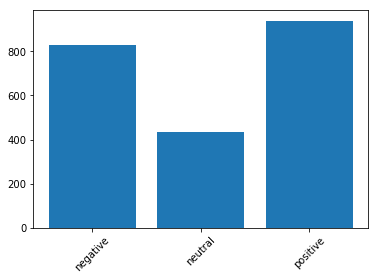

In [143]:
ul = [1,-1,0]
plt.bar(ul,labels.value_counts())
plt.xticks(ul,['positive','negative','neutral'],rotation=45)

In [156]:
type(X)

scipy.sparse.csr.csr_matrix

In [170]:
messages = df[' text']
labels = df[' class']
ws = 5
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
messages = [message.replace("[comma]","") for message in messages]
messages = [message.lower() for message in messages]
messages = [tokenizer.tokenize(message) for message in messages]

from nltk.corpus import stopwords
stops = set(stopwords.words("english")) 
msgs = []
for message in messages:
    message = [word for word in message if word not in stops]
    msgs.append(message)
new_messages=[]
messages = msgs
messages = [" ".join(message) for message in messages]
for message,aspect_term in zip(messages,aspect_terms):
    new_message=[]
    message = message.replace(aspect_term,"aspect")
    message = message.split()
    for position,word in enumerate(message):
        if word == "aspect":

            start = position - ws
            if start < 0:
                start = 0
            stop = position + ws + 1
            for ii in range(start,stop):
                try:
                    new_message.append(message[ii])
                except :
                    continue
    new_message = " ".join(new_message)
    message = " ".join(message)
    new_message = new_message.replace("aspect",aspect_term)
    message = message.replace("aspect",aspect_term)
    new_messages.append(new_message)

    
messages = [message.split() for message in messages]

In [184]:
msg_lens = [len(message) for message in messages]
vocab = []
for message in messages:
    for word in message:
        vocab.append(word)
len(set(vocab))

3607

In [172]:
messages

[['staff', 'horrible', 'us'],
 ['completely',
  'fair',
  'redeeming',
  'factor',
  'food',
  'average',
  'make',
  'deficiencies',
  'teodora'],
 ['food',
  'uniformly',
  'exceptional',
  'capable',
  'kitchen',
  'proudly',
  'whip',
  'whatever',
  'feel',
  'like',
  'eating',
  'whether',
  'menu'],
 ['food',
  'uniformly',
  'exceptional',
  'capable',
  'kitchen',
  'proudly',
  'whip',
  'whatever',
  'feel',
  'like',
  'eating',
  'whether',
  'menu'],
 ['food',
  'uniformly',
  'exceptional',
  'capable',
  'kitchen',
  'proudly',
  'whip',
  'whatever',
  'feel',
  'like',
  'eating',
  'whether',
  'menu'],
 ['food', 'outstanding', 'little', 'perks', 'great'],
 ['food', 'outstanding', 'little', 'perks', 'great'],
 ['agreed',
  'favorite',
  'orrechiete',
  'sausage',
  'chicken',
  'usually',
  'waiters',
  'kind',
  'enough',
  'split',
  'dish',
  'half',
  'get',
  'sample',
  'meats'],
 ['agreed',
  'favorite',
  'orrechiete',
  'sausage',
  'chicken',
  'usually',


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [198]:
lstm_sizes = [128, 64]
vocab_size = len(set(vocab)) + 1 #add one for padding
embed_size = 300
epochs = 1
batch_size = 256
learning_rate = 0.1
keep_prob = 0.5

In [199]:
train_x, val_x, test_x, train_y, val_y, test_y = train_val_test_split(messages, labels, split_frac=0.80)

ValueError: invalid literal for int() with base 10: 'also'

In [1]:
def output_textfile(labels):
    f=open("output.txt","w+")
    for label_index in range(1,len(labels)+1):
        f.write(label_index+";;"+labels[label_index-1])